In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectFromModel
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
random_state=42
cross_validation_folds = 5
n_jobs = 2
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
print('*'*40, "train")
print(train_df.info())
print('*'*40, 'test')
print(test_df.info())

**************************************** train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1

In [4]:
random_state=42
cross_validation_folds = 5
n_jobs = 2
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
test_ids = test_df.Id
y = train_df.SalePrice
train_df.drop(['SalePrice'], inplace=True, axis=1)
combine = [train_df, test_df]
combined = pd.concat([train_df, test_df])
train_df.replace(['NaN', 'NA', 'nan'], np.nan, inplace=True)
test_df.replace(['NaN', 'NA', 'nan'], np.nan, inplace=True)
def fill_column_with_median_value(df, column):
    """
    fill numerical columns with median value
    fill categorial columns with most common values
    """
    if df[column].dtype=='float64':
        median_value = combined[column][combined[column].notnull()].median()
    elif df[column].dtype=='object':
        median_value = combined[column][combined[column].notnull()].mode()[0]
    else:
        print('-- fuck --'* 40)
    df[column] = df[column].fillna(median_value)
def find_columns_with_na_values(df):
    for column in df.columns:
        if df.loc[df[column].isnull()].size>0:
            yield column
for dataset in combine:
    dataset.drop(['Id', 'Alley', 'PoolQC', 'MiscFeature', 'Fence'], inplace=True, axis=1)
    for column in find_columns_with_na_values(dataset):
        fill_column_with_median_value(dataset, column)

In [5]:
categorical_columns = list(filter(lambda col: train_df[col].dtype=='object', list(train_df.columns)))
mapping = dict()
# get the mapping between column labels to values
for column in categorical_columns:
    combined[column] = combined[column].astype('category')
    mapping[column] = dict(zip(combined[column].cat.categories, np.linspace(0, 1, len(combined[column].cat.categories))))
print(mapping)
for dataset in combine:
    dataset.replace(mapping, inplace=True)
print(train_df.shape, test_df.shape)

{'MSZoning': {'C (all)': 0.0, 'FV': 0.25, 'RH': 0.5, 'RL': 0.75, 'RM': 1.0}, 'Street': {'Grvl': 0.0, 'Pave': 1.0}, 'LotShape': {'IR1': 0.0, 'IR2': 0.3333333333333333, 'IR3': 0.6666666666666666, 'Reg': 1.0}, 'LandContour': {'Bnk': 0.0, 'HLS': 0.3333333333333333, 'Low': 0.6666666666666666, 'Lvl': 1.0}, 'Utilities': {'AllPub': 0.0, 'NoSeWa': 1.0}, 'LotConfig': {'Corner': 0.0, 'CulDSac': 0.25, 'FR2': 0.5, 'FR3': 0.75, 'Inside': 1.0}, 'LandSlope': {'Gtl': 0.0, 'Mod': 0.5, 'Sev': 1.0}, 'Neighborhood': {'Blmngtn': 0.0, 'Blueste': 0.041666666666666664, 'BrDale': 0.08333333333333333, 'BrkSide': 0.125, 'ClearCr': 0.16666666666666666, 'CollgCr': 0.20833333333333331, 'Crawfor': 0.25, 'Edwards': 0.29166666666666663, 'Gilbert': 0.3333333333333333, 'IDOTRR': 0.375, 'MeadowV': 0.41666666666666663, 'Mitchel': 0.4583333333333333, 'NAmes': 0.5, 'NPkVill': 0.5416666666666666, 'NWAmes': 0.5833333333333333, 'NoRidge': 0.625, 'NridgHt': 0.6666666666666666, 'OldTown': 0.7083333333333333, 'SWISU': 0.75, 'Sawye

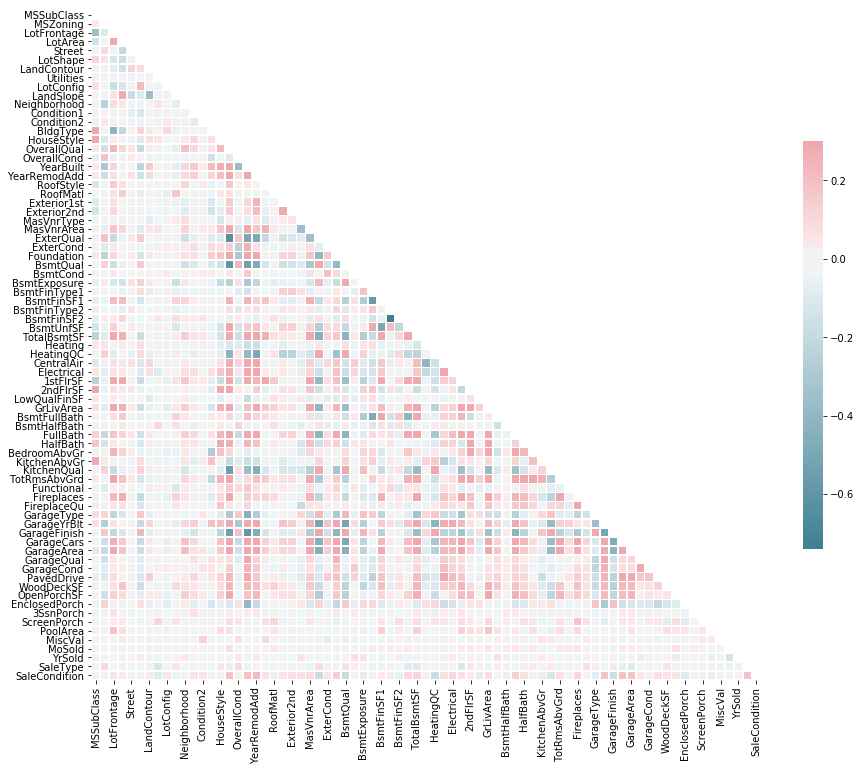

In [13]:
# Generate a mask for the upper triangle
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train_df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
train_df.to_csv("train_df_processed.csv")

## Apply baseline model - Linear Regression

In [6]:
rdf = LinearRegression()
cv = cross_val_score(rdf, train_df, y, cv=cross_validation_folds, n_jobs=n_jobs, verbose=1)
print("baseline model with linear regression, performance = {}".format(cv))
# rdf.fit(train_df, y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


baseline model with linear regression, performance = [0.87752436 0.81101046 0.85191571 0.84514085 0.66487085]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


before reduced shape (1460, 75) (1459, 75)
** before reduced = [0.90379358 0.84615212 0.89467259 0.90070475 0.89222512]
reduced shape (1460, 22) (1459, 22)


/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.6s finished


** after reduced = [0.90893548 0.854222   0.89651126 0.89455615 0.89566519]


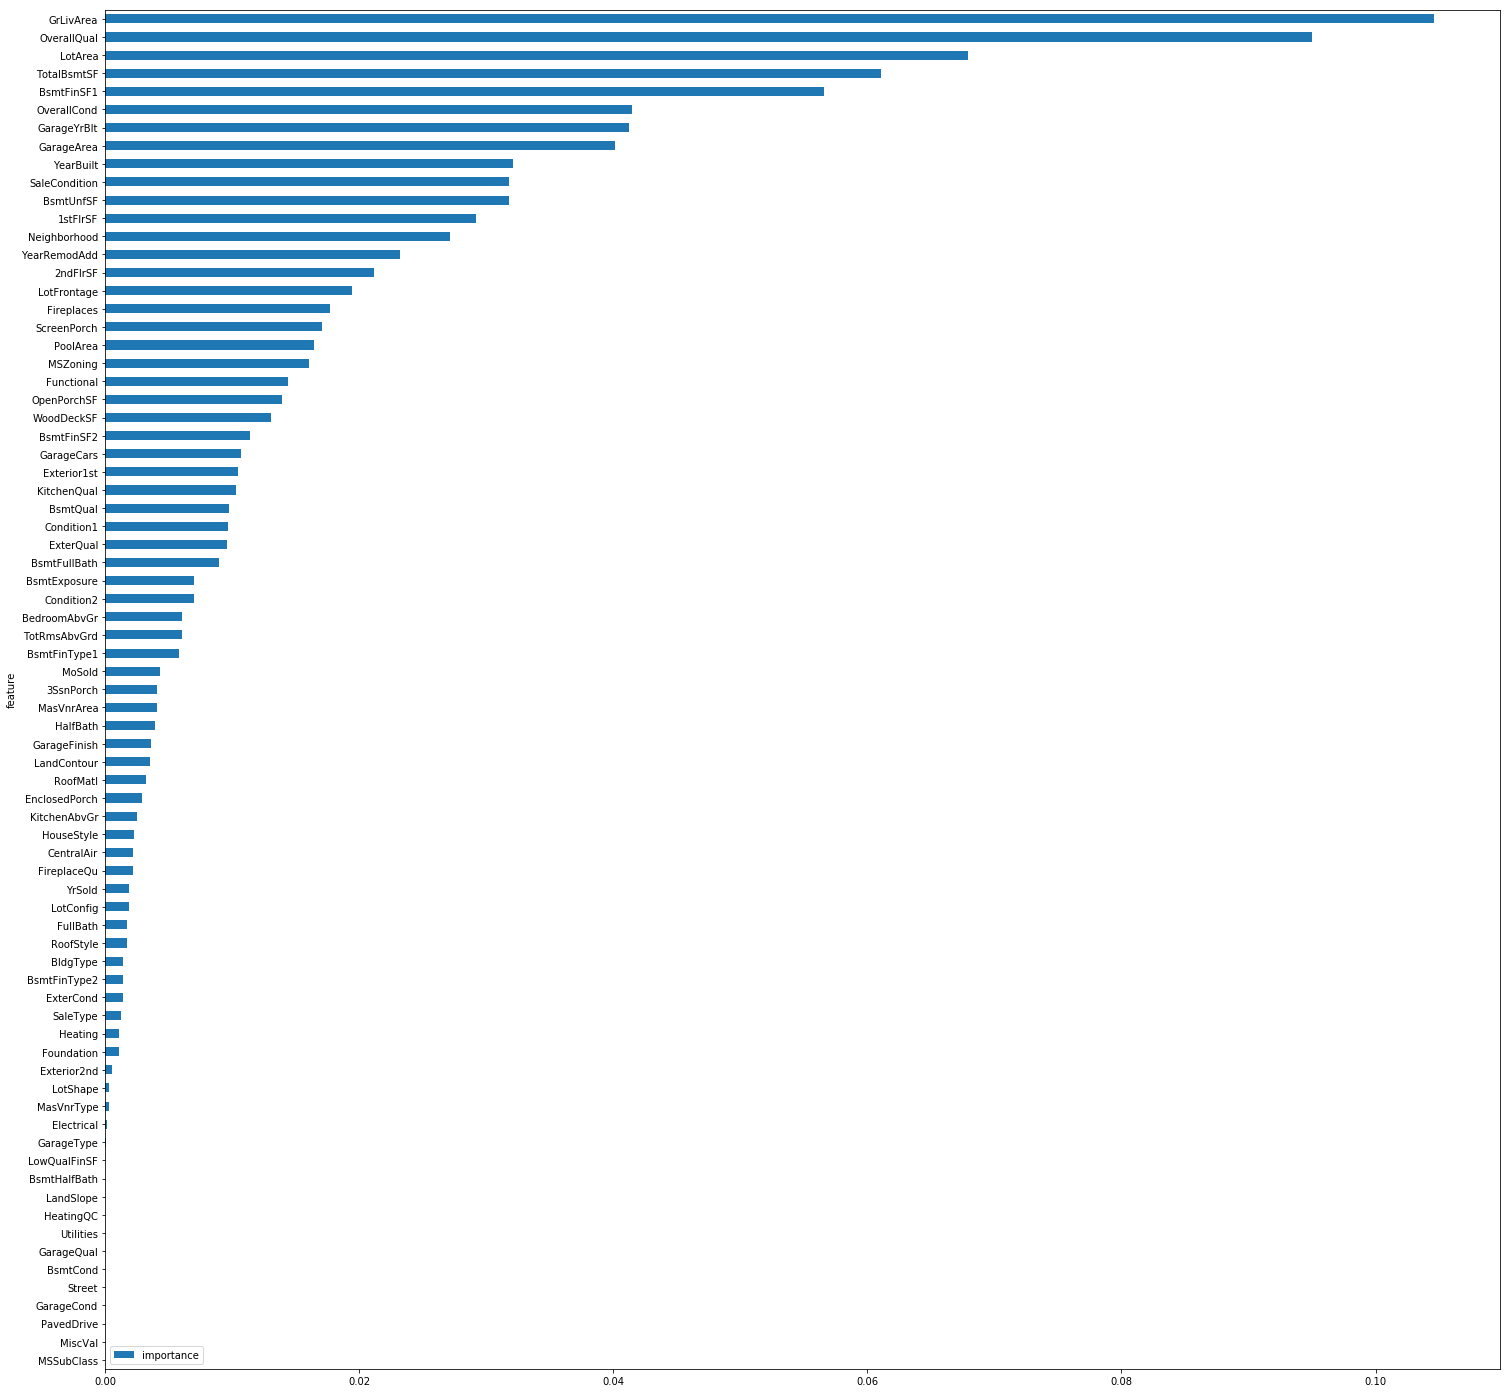

In [70]:
cv = cross_val_score(GradientBoostingRegressor(), train_df, y, cv=cross_validation_folds, n_jobs=n_jobs, verbose=1)
print(f"before reduced shape", train_df.shape, test_df.shape)
print(f"** before reduced = {cv}")
features = pd.DataFrame()
features['feature'] = train_df.columns
features['importance'] = rdf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))
model = SelectFromModel(rdf, prefit=True)
train_reduced = model.transform(train_df)
test_reduced = model.transform(test_df)
print("reduced shape", train_reduced.shape, test_reduced.shape)
cv = cross_val_score(GradientBoostingRegressor(), train_reduced, y, cv=cross_validation_folds, n_jobs=n_jobs, verbose=1)
print(f"** after reduced = {cv}")

In [55]:
y_pred = rdf.predict(test_df)
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": y_pred
})
submission.to_csv('house_price_result_baseline_random_forest_all_nan_filled.csv', index=False)

In [56]:
! kaggle competitions submit house-prices-advanced-regression-techniques -f house_price_result_baseline_random_forest_all_nan_filled.csv \
-m "baseline model with gradient boosting, feature engineer and nan processed"

Successfully submitted to House Prices: Advanced Regression Techniques

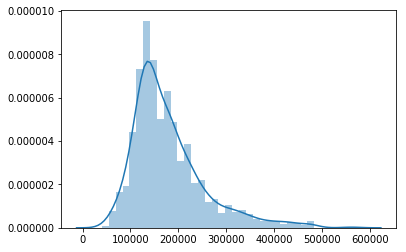

In [54]:
sns.distplot(y_pred)

## applying neural network

In [15]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, input_dim=75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, input_dim=75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [16]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=random_state)
results = cross_val_score(pipeline, train_df, y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -3566274570.28 (1697642894.71) MSE
